# CLIP - Contrastive Language-Image Pre-Training
This notebook will introduce the concept of multi-modality, that is when one model can handle multiple modalities of data e.g. images and language. You've most likely interacted with something like ChatGPT on images and receive a textual response. Indeed, ChatGPT is multi-modal.

The CLIP architecture handles language and image modalities. It does this via an embedding space, that is, a space where both text and images reside. The intuition behind an embedding space is that the input is transformed to an embedding i.e. a vector, where text and images which are similar also have embeddings which are similar in the embedding space. So, for example, an image of a gorilla and the sentence “an image of a gorilla" would end up having very similar embeddings and be close to each other in the vector space.

Authors: Albin Åberg Dahlberg, Stina Brunzell, Paul Häusner <br>
Last update: 05.12.2024

## Imports

In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import transformers

from PIL import Image

from urllib.request import urlopen
from urllib.error import URLError

import gzip
import pandas as pd

## We'll use a small sample of the WIT dataset - Wikipedia-based Image Text dataset
For those who want a closer look at how the data was curated: https://github.com/google-research-datasets/wit

The following code block downloads the sample into a dataframe


In [2]:
!wget https://storage.googleapis.com/gresearch/wit/wit_v1.train.all-1percent_sample.tsv.gz

file_path = "wit_v1.train.all-1percent_sample.tsv.gz"

# Unzip the file and read into a dataframe
with gzip.open(file_path, 'rt') as f:
    df = pd.read_csv(f, sep='\t')

df.info()

--2024-12-17 08:02:23--  https://storage.googleapis.com/gresearch/wit/wit_v1.train.all-1percent_sample.tsv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 142.250.99.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267198461 (255M) [text/tab-separated-values]
Saving to: ‘wit_v1.train.all-1percent_sample.tsv.gz’

wit_v1.train.all-1p 100%[===================>] 254.82M  99.4MB/s    in 2.6s    

2024-12-17 08:02:26 (99.4 MB/s) - ‘wit_v1.train.all-1percent_sample.tsv.gz’ saved [267198461/267198461]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370373 entries, 0 to 370372
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   language                         368765 non-null  object
 1   page_url                         37037

We'll only use english samples, and drop any rows with nan cells.

In [3]:
df = df.loc[df['language'] == 'en']
# Only some columns are of interest
dataset = df[['image_url', 'hierarchical_section_title',
              'context_page_description']].reset_index(drop=True).dropna()

These are the images we'll use

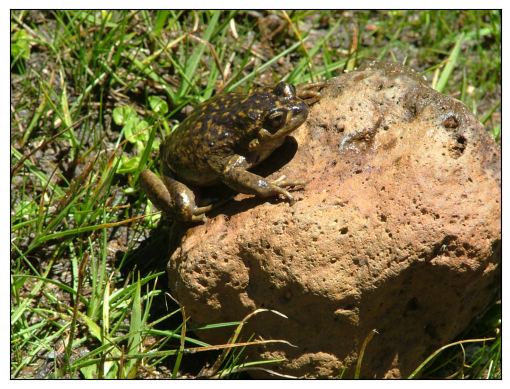

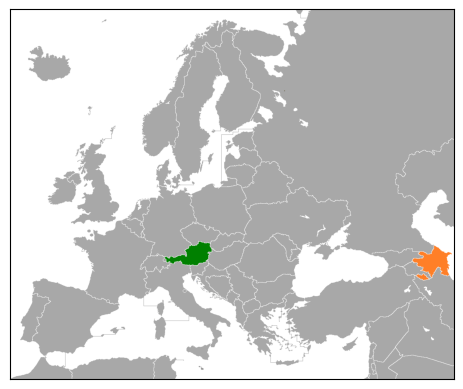

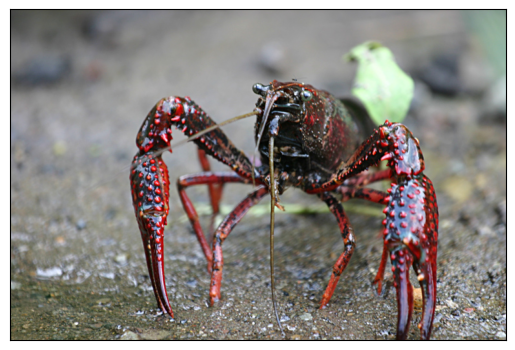

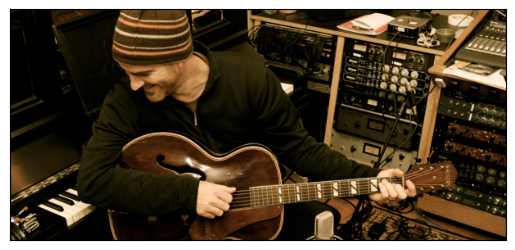

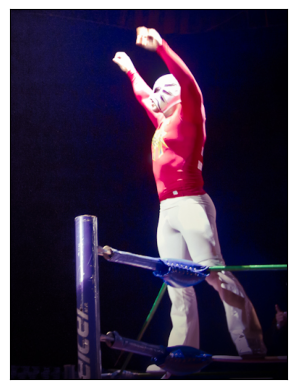

In [4]:
def plot_image(image_url):
  ''' Plots the image from an url '''
  try:
      with Image.open(urlopen(image_url)) as im:
          # The following fixes some problems when loading images:
          # https://stackoverflow.com/a/64598016
          image = im.convert("RGB")
  except (URLError, OSError):
      print("please provide a valid URL or local path")
  else:
      plt.imshow(np.asarray(image))
      plt.xticks([])
      plt.yticks([])
      plt.show()
      print()

# We select specific rows
INDECES = [6, 32, 51, 70, 82]
data = dataset.iloc[INDECES].reset_index(drop=True)

# Lets look at the images!
for i in range(len(data)):
  plot_image(data.iloc[i]['image_url'])

## Load in CLIP models
- `processor` transforms input to embeddings
- `model` predicts embeddings

In [5]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
def extract_image(image_url):
  ''' Extract images from urls to a list '''
  try:
      with Image.open(urlopen(image_url)) as im:
          # The following fixes some problems when loading images:
          # https://stackoverflow.com/a/64598016
          image = im.convert("RGB")
  except (URLError, OSError):
      print("please provide a valid URL or local path")

  return [image]

# We'll play a guessing game. Write a text that describes the image you see in `INPUT` and we'll see if it is more accurate than the other descriptions for the images!

In [7]:
def guessing_game(image_index, input):
  image_url = data.iloc[INDEX]['image_url']
  # Our image
  images = extract_image(image_url)
  # List for all descriptions
  descriptions = [input] + list(data['hierarchical_section_title'].values)

  with torch.no_grad():
      inputs = processor(text=descriptions, images=images, return_tensors="pt", padding=True, truncation=True)
      outputs = model(**inputs)

  dot_products_per_image = outputs.logits_per_image
  # Softmax on dot products to get prediction probabilities.
  probabilities = dot_products_per_image.softmax(dim=1).flatten()

  for i, desc in enumerate(descriptions):
    if len(desc) > 100:
      print(f"description: {desc[:100]}... --> p={probabilities[i]:.2f}")
    else:
      print(f"description: {desc} --> p={probabilities[i]:.2f}")

### Let's start with the first image
Write your guess in `INPUT` two blocks down

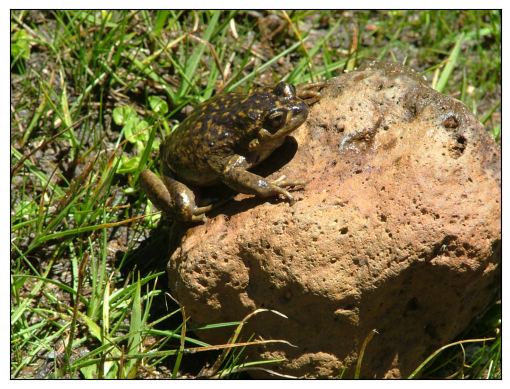

In [8]:
# Don't change the index
INDEX = 0
image_url = data.iloc[INDEX]['image_url']
plot_image(image_url)

In [9]:
# Write your description here
INPUT = "A frog"
guessing_game(INDEX, INPUT)

description: A frog --> p=0.73
description: Alsodes pehuenche --> p=0.02
description: Austria–Azerbaijan relations --> p=0.00
description: Cambaridae --> p=0.25
description: Ed Cash --> p=0.00
description: Mexican National Light Heavyweight Championship / Combined reigns --> p=0.00


If your text input has a higher output than the other text inputs, then the model thinks your descriptions is more similar to the image! Do note that the output probabilities are in relation to each other, change your input and the probabilities will also change.

Next image

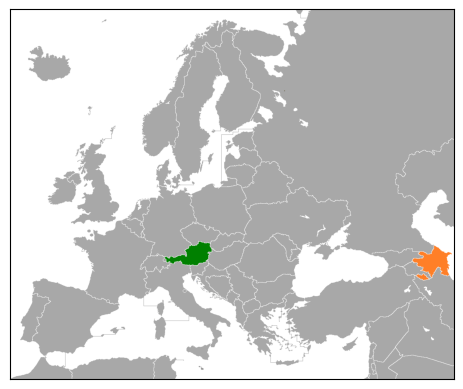

In [10]:
# Don't change the index
INDEX = 1
image_url = data.iloc[INDEX]['image_url']
plot_image(image_url)

In [11]:
# Write your description here
INPUT = ""
guessing_game(INDEX, INPUT)

description:  --> p=0.00
description: Alsodes pehuenche --> p=0.00
description: Austria–Azerbaijan relations --> p=1.00
description: Cambaridae --> p=0.00
description: Ed Cash --> p=0.00
description: Mexican National Light Heavyweight Championship / Combined reigns --> p=0.00


Next image

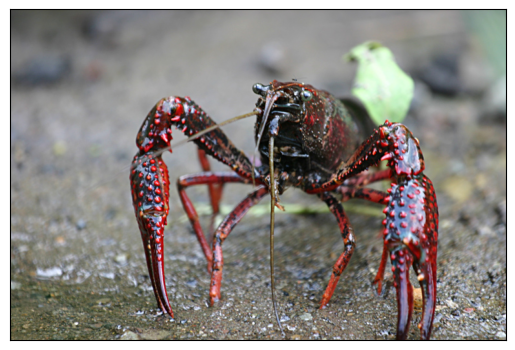

In [12]:
# Don't change the index
INDEX = 2
image_url = data.iloc[INDEX]['image_url']
plot_image(image_url)

In [13]:
# Write your description here
INPUT = ""
guessing_game(INDEX, INPUT)

description:  --> p=0.00
description: Alsodes pehuenche --> p=0.01
description: Austria–Azerbaijan relations --> p=0.00
description: Cambaridae --> p=0.99
description: Ed Cash --> p=0.00
description: Mexican National Light Heavyweight Championship / Combined reigns --> p=0.00


Next image

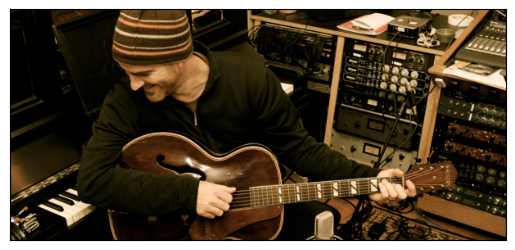

In [14]:
# Don't change the index
INDEX = 3
image_url = data.iloc[INDEX]['image_url']
plot_image(image_url)

In [15]:
# Write your description here
INPUT = ""
guessing_game(INDEX, INPUT)

description:  --> p=0.01
description: Alsodes pehuenche --> p=0.01
description: Austria–Azerbaijan relations --> p=0.00
description: Cambaridae --> p=0.00
description: Ed Cash --> p=0.97
description: Mexican National Light Heavyweight Championship / Combined reigns --> p=0.00


Last one

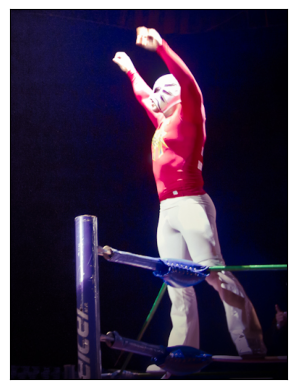

In [16]:
# Don't change the index
INDEX = 4
image_url = data.iloc[INDEX]['image_url']
plot_image(image_url)

In [17]:
# Write your description here
INPUT = ""
guessing_game(INDEX, INPUT)

description:  --> p=0.03
description: Alsodes pehuenche --> p=0.06
description: Austria–Azerbaijan relations --> p=0.00
description: Cambaridae --> p=0.04
description: Ed Cash --> p=0.27
description: Mexican National Light Heavyweight Championship / Combined reigns --> p=0.60
